# Lab 8
## Training Attacks

## Init Environment
To kick things off, let's first initialize the federated learning environment, building upon the foundational code introduced in Tutorial 1A.



In [ ]:
from lab_2_hfl.hfl_complete import *

sample_split = split(100, True, 42)
fedavg_server = FedAvgServer(0.02, 200, sample_split, 0.2, 2, 42)
result_fedavg = fedavg_server.run(10)
fedavg_df = result_fedavg.as_df()
fedavg_df

We will introduce a slight modification to the WeightClient and FedAvgServer components, implementing FedSGD instead.
Previously, clients were designed to upload their local model to the server.
In this updated approach, we shift the focus towards uploading the gradient instead. 
This gradient represents the difference between the updated local model and the prior local model following local training sessions on a single batch.

|                         | Previous Approach (Model Upload)                                       | Updated Approach (Gradient Upload)                                                                                                              |
|-------------------------|------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| **Equation for Update** | $$M_{\text{global}}^{t+1} = \frac{1}{N} \sum_{i=1}^{N} M_{i}^{(t+1)}$$ | $$M_{\text{global}}^{(t+1)} = M_{\text{global}}^{(t)} - \frac{1}{N} \sum_{i=1}^{N} g_{i}^{(t)}$$ where $$ g_i^{(t)}=M_{i}^{(t)}-M_{i}^{(t+1)}$$ |

In [ ]:
class GradWeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.nr_epochs = nr_epochs
        self.data_len = len(self.loader_train)
        self.data_iter = iter(self.loader_train)
    

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        assert self.nr_epochs > 0, "Number of local epochs must be greater than 0"
        gradients = None

        for _epoch in range(self.nr_epochs):
            self.model.train()
            # get one next batch in dataloader
            data, target = next(self.data_iter, (None, None))
            if data is None or target is None:
                # we started a new epoch, reset the data iterator and get the first batch
                self.data_iter = iter(self.loader_train)
                data, target = next(self.data_iter)
            data, target = data.to(device), target.to(device)
            output = self.model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            gradients = [param.grad.detach().cpu().clone() for param in self.model.parameters()]

        # Calculate gradients: initial_weights - final_weights
        return gradients


class FedSGDGradServer(DecentralizedServer):
    def __init__(
        self, lr: float, batch_size: int, client_subsets: list[Subset], nr_local_epochs: int, seed: int
    ) -> None:
        super().__init__(lr, batch_size, client_subsets, 1.0, seed)
        self.name = "FedSGD"
        self.nr_local_epochs = nr_local_epochs
        self.batch_size = batch_size

        self.clients = [GradWeightClient(subset, lr, batch_size, nr_local_epochs) for subset in client_subsets]
        self.data_max_len = max(len(client.loader_train) for client in self.clients)

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.0
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed
        )


        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            # Other code remains the same, but we perform an attack on a specific gradient
            setup_start_time = perf_counter()
            self.model.train()
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            for data_through in tqdm(range(self.data_max_len), desc="Data Through", leave=False):
                weights = [x.detach().cpu().clone() for x in self.model.parameters()]
                chosen_adjusted_weights: list[list[torch.Tensor]] = []

                for c_i in range(self.nr_clients):
                    update_start_time = perf_counter()
                    ind = int(c_i)
                    client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients + data_through * self.nr_clients * nr_rounds
                    client_gradients = self.clients[ind].update(weights, client_round_seed)  # gradients for 1 batch

                    chosen_adjusted_weights.append([tens * self.lr / self.nr_clients for tens in client_gradients])
                    update_time = max(update_time, perf_counter() - update_start_time)

                elapsed_time += update_time
                aggregate_start_time = perf_counter()

                # Update server model with averaged gradients
                with torch.no_grad():
                    for current_gradients in chosen_adjusted_weights:
                        for server_weight, gradient in zip(weights, current_gradients):
                            server_weight -= gradient  # Assume learning rate is applied earlier

                # Distribute updated weights to clients
                with torch.no_grad():
                    for param, server_weight in zip(self.model.parameters(), weights):
                        param.data[:] = server_weight.data.to(device)

                elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.test_accuracy.append(self.test())
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            tqdm.write(f"Round {nr_round + 1}/{nr_rounds} - Test Accuracy: {run_result.test_accuracy[-1]:.4f}")

        return run_result

Upon examination, we can see that both methods will converge to a good model, although at different costs.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_split = split(100, True, 42)
fedsgd_server = FedSGDGradServer(lr=0.02, batch_size=200, client_subsets=small_split, nr_local_epochs=1, seed=42)
result_fedsgd = fedsgd_server.run(10) # set number of global rounds
fedsgd_df = result_fedsgd.as_df()
fedsgd_df

## Backdoor Attacks
Backdoor attacks represent a sophisticated and stealthy subset of data poisoning techniques in machine learning, particularly concerning in federated learning scenarios. Unlike conventional poisoning strategies that aim to degrade overall model performance, backdoor attacks are designed with subtlety and specificity in mind. They introduce a malicious function into the model that is activated only under certain conditions—specifically, when a particular pattern, or "trigger," is present in the input data.
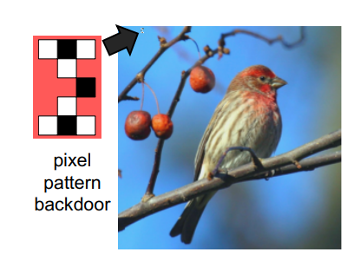

Let's begin by developing code for a synthesizer that will introduce triggers into our data.

In [ ]:
import random

# a new data class that help us to process batch
@dataclass
class Batch:
    batch_id: int
    inputs: torch.Tensor
    labels: torch.Tensor

    def __post_init__(self):
        self.batch_size = self.inputs.shape[0]

    def to(self, device):
        inputs = self.inputs.to(device)
        labels = self.labels.to(device)
        return Batch(self.batch_id, inputs, labels)

    def clone(self):
        inputs = self.inputs.clone()
        labels = self.labels.clone()
        return Batch(self.batch_id, inputs, labels)


    def clip(self, batch_size):
        if batch_size is None:
            return self

        inputs = self.inputs[:batch_size]
        labels = self.labels[:batch_size]

        return Batch(self.batch_id, inputs, labels)

class Synthesizer:
    def __init__(self, poisoning_proportion):
        self.poisoning_proportion = poisoning_proportion

    def make_backdoor_batch(self, batch: Batch, test=False, attack=True) -> Batch:
        if not attack:
            return batch

        if test:
            attack_portion = batch.batch_size
        else:
            attack_portion = round(
                batch.batch_size * self.poisoning_proportion)

        backdoored_batch = batch.clone()
        self.apply_backdoor(backdoored_batch, attack_portion)
        return backdoored_batch

    def apply_backdoor(self, batch, attack_portion):
        """
        Modifies only a portion of the batch (represents batch poisoning).

        :param batch:
        :return:
        """
        self.synthesize_inputs(batch=batch, attack_portion=attack_portion)
        self.synthesize_labels(batch=batch, attack_portion=attack_portion)

        return

    def synthesize_inputs(self, batch, attack_portion=None):
        raise NotImplemented

    def synthesize_labels(self, batch, attack_portion=None):
        raise NotImplemented

class PatternSynthesizer(Synthesizer):
    pattern_tensor: torch.Tensor = torch.tensor([
        [1., 0., 1.],
        [-10., 1., -10.],
        [-10., -10., 0.],
        [-10., 1., -10.],
        [1., 0., 1.]
    ])
    "Just some random 2D pattern."

    x_top = 3
    "X coordinate to put the backdoor into."
    y_top = 23
    "Y coordinate to put the backdoor into."

    mask_value = -10
    "A tensor coordinate with this value won't be applied to the image."

    resize_scale = (5, 10)
    "If the pattern is dynamically placed, resize the pattern."

    mask: torch.Tensor = None
    "A mask used to combine backdoor pattern with the original image."

    pattern: torch.Tensor = None
    "A tensor of the `input.shape` filled with `mask_value` except backdoor."

    def __init__(self, poisoning_proportion):
        super().__init__(poisoning_proportion)
        self.input_shape = (1, 28, 28)
        self.backdoor_label = 0
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        self.make_pattern(self.pattern_tensor, self.x_top, self.y_top)


    def make_pattern(self, pattern_tensor, x_top, y_top):
        # put pattern into the image
        full_image = torch.zeros(self.input_shape)
        full_image.fill_(self.mask_value)
        # full image has a pixel value of -10
        x_bot = x_top + pattern_tensor.shape[0]
        y_bot = y_top + pattern_tensor.shape[1]

        if x_bot >= self.input_shape[1] or \
                y_bot >= self.input_shape[2]:
            raise ValueError(f'Position of backdoor outside image limits:'
                             f'image: {self.input_shape}, but backdoor'
                             f'ends at ({x_bot}, {y_bot})')

        full_image[:, x_top:x_bot, y_top:y_bot] = pattern_tensor
        # full image has a pixel value of -10 except for the backdoor (pattern_tensor) size: 5 * 3
        self.mask = 1 * (full_image != self.mask_value).to(device) # (0, 1)
        # mask is a tensor of 0 and 1, 0 for -10 and 1 for other values
        self.pattern = self.normalize(full_image).to(device) # )(-52.5678, 2.7537)


    def synthesize_inputs(self, batch, attack_portion=None):
        pattern, mask = self.get_pattern()
        # mask value (0, 1); value 0, keep the original image; value 1, replace with pattern
        batch.inputs[:attack_portion] = (1 - mask) * \
                                        batch.inputs[:attack_portion] + \
                                        mask * pattern

        return

    def synthesize_labels(self, batch, attack_portion=None):
        batch.labels[:attack_portion].fill_(self.backdoor_label)
        return

    def get_pattern(self):
        return self.pattern, self.mask

In [ ]:
test_syn_loader = DataLoader(
    datasets.MNIST(data_path, train=False, download=False, transform=transform),
    shuffle=False, drop_last=False, batch_size=10, generator=torch.Generator())

# Instantiate the synthesizer with a poisoning proportion
poisoning_proportion = 0.5
synthesizer = PatternSynthesizer(poisoning_proportion=poisoning_proportion)

# Fetch a test batch
for batch_idx, (inputs, labels) in enumerate(test_syn_loader):
    test_batch = Batch(batch_idx, inputs, labels)
    test_batch = test_batch.to(device)
    break  # Only take the first batch for testing

# Apply backdoor
backdoored_batch = synthesizer.make_backdoor_batch(test_batch, test=False, attack=True)

In the code snippet provided, invoking the synthesizer.make_backdoor_batch function results in half of the data within a batch being compromised with backdoor triggers.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images_to_show = 10
# Define the function for displaying an image
def imshow(img, ax, title=""):
    # img is a torch.Tensor
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy format and change order to HxWxC
    # Undo normalization
    mean = np.array([0.1307])
    std = np.array([0.3081])
    img = std * img + mean  # This line undoes the normalization applied to the images
    img = np.clip(img, 0, 1)  # Ensure the image's values are between 0 and 1 so plt can plot it correctly
    ax.imshow(img)
    if title:
        ax.set_title(title)
    ax.axis('off')

# Create figure with subplots
fig, axs = plt.subplots(2, images_to_show, figsize=(15, 4))

# Display original images
for i in range(images_to_show):
    imshow(test_batch.inputs[i], axs[0, i], f"Original: {test_batch.labels[i].item()}")

# Display backdoored images
for i in range(images_to_show):
    imshow(backdoored_batch.inputs[i], axs[1, i], f"Backdoor: {backdoored_batch.labels[i].item()}")

plt.show()


In [ ]:
class AttackerBackdoor(GradWeightClient):

    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, lr, batch_size, nr_epochs)
        self.batch_counter = 0

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        assert self.nr_epochs > 0, "Number of local epochs must be greater than 0"
        gradients = None

        for _epoch in range(self.nr_epochs):
            self.model.train()
            # get one next batch in dataloader
            data, target = next(self.data_iter, (None, None))
            if data is None or target is None:
                # we started a new epoch, reset the data iterator and get the first batch
                self.data_iter = iter(self.loader_train)
                data, target = next(self.data_iter)
            # here we attack now

            data, target = ..., ...
            
            self.batch_counter += 1
            
            output = self.model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            gradients = [param.grad.detach().cpu().clone() for param in self.model.parameters()]

        return gradients

In [ ]:
fedavg_server_backdoor = FedSGDGradServer(lr=0.02, batch_size=200, client_subsets=sample_split, nr_local_epochs=1, seed=42)
clients = fedavg_server_backdoor.clients
# Number of clients to be made malicious with backdoor
attacker_proportion = 0.25
num_malicious = int(attacker_proportion * len(clients))
# Randomly select indices for the clients to undergo backdoor attack
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

# Replace the selected clients with instances of AttackerGradientInversion
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, 0.02, batch_size, nr_epochs)

result_fedavg_backdoor = fedavg_server_backdoor.run(10)
fedavg_df_backdoor = result_fedavg_backdoor.as_df()
fedavg_df_backdoor

From the previous results, we can find that the global test acuracy are not influnced by the backdoor attacks too much. That's beacuse all of the test data are without trigger. Now let's add trigger to our dataset.

In [ ]:
def confusion_matrix_backdoor(model, test_loader: DataLoader, num_classes: int) -> tuple[float, float, np.ndarray]:
    correct = 0
    success = 0
    model.eval()
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(batch, test=True, attack=True)
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct +=  pred.eq(batch.labels.view_as(pred)).sum().item()
            success += pred.eq(target.view_as(pred)).sum().item()

            # Update confusion matrix
            for t, p in zip(batch.labels.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100. * correct / len(test_loader.dataset)
    success_rate = 100. * success / len(test_loader.dataset)
    return accuracy, success_rate, confusion_matrix

accuracy, success_rate, confusion_matrix = confusion_matrix_backdoor(fedavg_server_backdoor.model, test_loader, 10)
print(f'The global test accuracy is {accuracy}%')
print(f'The attack success_rate is {success_rate}%')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(confusion_matrix, class_names=[str(i) for i in range(10)])

# Gradient Inversion


Until now, we considered scenarios where the malicious party was a client.
The next attack can be performed by the federator instead.

In [ ]:
def imshow_pair(original, reconstructed, title_suffix=""):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    imshow(original, axs[0], f"Original")
    imshow(reconstructed, axs[1], f"Reconstructed {title_suffix}")
    plt.show()

HOW_MANY_VICTIMS = 5

![gradinv](gradinv.png)

[source](https://arxiv.org/abs/2206.07284)

In [ ]:
class VictimGradWeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.nr_epochs = nr_epochs
        self.data_len = len(self.loader_train)
        self.data_iter = iter(self.loader_train)
    

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        self.model.train()
        # get one next batch in dataloader
        data, target = next(self.data_iter, (None, None))
        if data is None or target is None:
            # we started a new epoch, reset the data iterator and get the first batch
            self.data_iter = iter(self.loader_train)
            data, target = next(self.data_iter)
        data, target = data.to(device), target.to(device)
        output = self.model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        gradients = [param.grad.detach().cpu().clone() for param in self.model.parameters()]

        return gradients, data, target

# Attacker server

class FedSGDAttackingGradServer(DecentralizedServer):
    def __init__(
        self, lr: float, batch_size: int, client_subsets: list[Subset], nr_local_epochs: int, seed: int
    ) -> None:
        super().__init__(lr, batch_size, client_subsets, 1.0, seed)
        self.name = "FedSGD"
        self.nr_local_epochs = nr_local_epochs
        self.batch_size = batch_size

        self.clients = [VictimGradWeightClient(subset, lr, batch_size, nr_local_epochs) for subset in client_subsets]
        self.data_max_len = max(len(client.loader_train) for client in self.clients)
        self.data_shape = client_subsets[0][0][0].shape

    
    def attack(self, gradient, labels, ground_truth=None):
        # create dummy data, same shape as batch
        dummy_data = torch.randn((self.batch_size, *self.data_shape), device=device, requires_grad=True)
        dummy_labels = labels.to(device)

        optimizer = torch.optim.Adam(params=[dummy_data], lr=0.06)
        self.model.eval()
        for _ in range(1500):  # Number of optimization steps to recover the batch. This has very diminishing returns
            optimizer.zero_grad()
            # Forward pass with dummy data
            ...            
            # Backpropagate the difference to update the dummy data
            optimizer.step()

        dummy_data = dummy_data.detach().cpu()

        if ground_truth is not None:
            # tqdm.write(f"GT Loss: {gt_loss.item():.4f}")
            imshow_pair(ground_truth[0], dummy_data[0])
        
        return dummy_data

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.0
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed
        )


        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            # Other code remains the same, but we perform an attack on a specific gradient
            setup_start_time = perf_counter()
            self.model.train()
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            for data_through in tqdm(range(self.data_max_len), desc="Data Through", leave=False):
                weights = [x.detach().cpu().clone() for x in self.model.parameters()]
                chosen_adjusted_weights: list[list[torch.Tensor]] = []

                for c_i in range(self.nr_clients):
                    if c_i >= HOW_MANY_VICTIMS:
                        return run_result
                    update_start_time = perf_counter()
                    ind = int(c_i)
                    client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients + data_through * self.nr_clients * nr_rounds
                    client_gradients, ground_truth_data, ground_truth_labels  = self.clients[ind].update(weights, client_round_seed)  # gradients for 1 batch

                    reconstructed_data = self.attack(client_gradients, ground_truth_labels, ground_truth_data)


                    chosen_adjusted_weights.append([tens * self.lr / self.nr_clients for tens in client_gradients])
                    update_time = max(update_time, perf_counter() - update_start_time)

                elapsed_time += update_time
                aggregate_start_time = perf_counter()

                # Update server model with averaged gradients
                with torch.no_grad():
                    for current_gradients in chosen_adjusted_weights:
                        for server_weight, gradient in zip(weights, current_gradients):
                            server_weight -= gradient  # Assume learning rate is applied earlier

                # Distribute updated weights to clients
                with torch.no_grad():
                    for param, server_weight in zip(self.model.parameters(), weights):
                        param.data[:] = server_weight.data.to(device)

                elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.test_accuracy.append(self.test())
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)

        return run_result


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fedsgd_server = FedSGDAttackingGradServer(lr=0.02, batch_size=1, client_subsets=sample_split, nr_local_epochs=1, seed=42)
result_fedsgd = fedsgd_server.run(1)

# Bonus
## Unknown Label Inversion

We have seen that the attack requires knowledge of the labels. This is not super realistic, so attackers have different strategies to recover this info.

## Integer optimization

If we know that the labels are for example the number 0-9, we can optimize a `dummy_label` tensor of length `10`. Before each optimization run we run `softmax` over the tensor to obtain the current most likely label index and use that to compute the loss.

In [ ]:
class VictimGradWeightClientNoLabel(VictimGradWeightClient):

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:

        gradients, data, target = super().update(weights, seed)
        return gradients, data, None

# Attacker server

class FedSGDAttackingGradServerNoLabelsOpt(FedSGDAttackingGradServer):
    def __init__(
        self, lr: float, batch_size: int, client_subsets: list[Subset], nr_local_epochs: int, seed: int
    ) -> None:
        super().__init__(lr, batch_size, client_subsets, 1.0, seed)
        self.name = "FedSGD"
        self.nr_local_epochs = nr_local_epochs
        self.batch_size = batch_size

        self.clients = [VictimGradWeightClientNoLabel(subset, lr, batch_size, nr_local_epochs) for subset in client_subsets]
        self.data_max_len = max(len(client.loader_train) for client in self.clients)
        self.data_shape = client_subsets[0][0][0].shape

# Implement such optimization here

    def attack(self, gradient, labels, ground_truth=None):
        # create dummy data, same shape as batch
        dummy_data = torch.randn((self.batch_size, *self.data_shape), device=device, requires_grad=True)
        # make a length 10 tensor to optimize, sum=1 for softmax later
        dummy_labels = ...

        optimizer = torch.optim.Adam(params=[dummy_data, dummy_labels], lr=0.06)
        self.model.eval()
        for _ in range(1500):  # Number of optimization steps to recover the batch. This has very diminishing returns
            optimizer.zero_grad()
            
            output = self.model(dummy_data)
           
            # Get current label probabilities
            dummy_labels_probs = ...
            
            # Compute differentiable NLL Loss by hand using the softmax probabilities
            loss = ...
            
            # Backpropagate the difference to update the dummy data and labels
            optimizer.step()

        dummy_data = dummy_data.detach().cpu()

        if ground_truth is not None:
            # tqdm.write(f"GT Loss: {gt_loss.item():.4f}")
            imshow_pair(ground_truth[0], dummy_data[0], title_suffix=f"Optimized labels: {dummy_labels.argmax(dim=1)[0].item()}")
        
        return dummy_data


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fedsgd_server = FedSGDAttackingGradServerNoLabelsOpt(lr=0.02, batch_size=1, client_subsets=sample_split, nr_local_epochs=1, seed=42)
result_fedsgd = fedsgd_server.run(1)

## One-Shot Label Inversion

[This paper](https://arxiv.org/pdf/2001.02610) proposed a way to extract the ground-truth labels.
The full math can be daunting, but it's actually quite straight forward.

Remember that the last logits layer represents the likelihood of each label.
Then consider the gradient of the last layer before the output.
For each possible label, the gradient will depend on the negative log-likelihood as loss.
If you look at the figure, where `g_i` is the gradient for label `i` and `c` is the correct label, we can see that the gradients will have the `-1` term only where the label is correct.
We can then find the negative (minimum) value and use it to identify the real label.


![](label-oneshot.png)

In [ ]:
class FedSGDAttackingGradServerNoLabelsDirect(FedSGDAttackingGradServer):
    def __init__(
        self, lr: float, batch_size: int, client_subsets: list[Subset], nr_local_epochs: int, seed: int
    ) -> None:
        super().__init__(lr, batch_size, client_subsets, 1.0, seed)
        self.name = "FedSGD"
        self.nr_local_epochs = nr_local_epochs
        self.batch_size = batch_size

        self.clients = [VictimGradWeightClientNoLabel(subset, lr, batch_size, nr_local_epochs) for subset in client_subsets]
        self.data_max_len = max(len(client.loader_train) for client in self.clients)
        self.data_shape = client_subsets[0][0][0].shape

# Implement such optimization here
# Only attack function for brevity

    def attack(self, gradient, labels, ground_truth=None):
        # create dummy data, same shape as batch
        dummy_data = torch.randn((self.batch_size, *self.data_shape), device=device, requires_grad=True)
        dummy_labels = labels.to(device)

        optimizer = torch.optim.Adam(params=[dummy_data], lr=0.06)
        self.model.eval()
        for _ in range(1500):  # Number of optimization steps to recover the batch. This has very diminishing returns
            optimizer.zero_grad()
            # Forward pass with dummy data
            ...            
            # Backpropagate the difference to update the dummy data
            optimizer.step()

        dummy_data = dummy_data.detach().cpu()

        if ground_truth is not None:
            # tqdm.write(f"GT Loss: {gt_loss.item():.4f}")
            imshow_pair(ground_truth[0], dummy_data[0])
        
        return dummy_data


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fedsgd_server = FedSGDAttackingGradServerNoLabelsDirect(lr=0.02, batch_size=1, client_subsets=sample_split, nr_local_epochs=1, seed=42)
result_fedsgd = fedsgd_server.run(1)

## 